In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import string
import contractions
import re
import unicodedata

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer
from plotnine import *
%matplotlib inline

## Clean df

In [15]:
df = pd.read_json('../../data/ssc/ssc_data.json')
df.head()

,date,title,author,num_comments,content
0,NaT,Archives | Slate Star Codex,None,11 Responses to,"<div class=""pjgm-postcontent"">\n\t\t\t\t\t\t<d..."
1,NaT,Advertise | Slate Star Codex,None,None,"<div class=""pjgm-postcontent"">\n\t\t\t\t\t\t<p..."
2,NaT,Mistakes | Slate Star Codex,None,40 Responses to,"<div class=""pjgm-postcontent"">\n\t\t\t\t\t\t<p..."
3,NaT,Comments | Slate Star Codex,None,138 Responses to,"<div class=""pjgm-postcontent"">\n\t\t\t\t\t\t<p..."
4,NaT,\n\tComments for Slate Star Codex\t,None,None,None


In [16]:
df.isna().sum()

date             9
title            0
author           9
num_comments    13
content          5
dtype: int64

In [17]:
df = df[~df.date.isna()]

In [18]:
df.isna().sum()

date            0
title           0
author          0
num_comments    8
content         1
dtype: int64

In [19]:
#exclude recent data
df = df[df['date']<'04-15-2020']

In [20]:
#fix comments
df['num_comments'] = df['num_comments'].fillna('0 Responses to')
for k,v in {' Responses to': '', ',' :'', 'One': '1', 'Response to':''}.items():
    df['num_comments'] = df['num_comments'].str.replace(k,v)
df['num_comments'] = df['num_comments'].astype(int)

In [21]:
#fix title
df.title = df.title.str.replace(' \| Slate Star Codex', '')

In [22]:
df.head()

,date,title,author,num_comments,content
15,2020-04-14,"A Failure, But Not Of Prediction",Scott Alexander,894,"<div class=""pjgm-postcontent"">\n\t\t\t\t\t\t<p..."
16,2020-04-08,2019 Predictions: Calibration Results,Scott Alexander,92,"<div class=""pjgm-postcontent"">\n\t\t\t\t\t\t<p..."
17,2020-04-12,Open Thread 151.5,a reader,1306,"<div class=""pjgm-postcontent"">\n\t\t\t\t\t\t<p..."
18,2020-04-07,Never Tell Me The Odds (Ratio),Scott Alexander,19,"<div class=""pjgm-postcontent"">\n\t\t\t\t\t\t<p..."
19,2020-04-06,SSCJC: Real World Depression Measurement,Scott Alexander,65,"<div class=""pjgm-postcontent"">\n\t\t\t\t\t\t<p..."


In [23]:
def fix_content(content):
    soup = BeautifulSoup(content, 'html.parser')
    text = soup.get_text() 
    text = unicodedata.normalize("NFKD", text) 
    text = text.replace('\n', ' ')
    return text

In [24]:
df['content'] = df['content'].apply(fix_content)
df.head()

,date,title,author,num_comments,content
15,2020-04-14,"A Failure, But Not Of Prediction",Scott Alexander,894,I. Vox asks What Went Wrong With The Media’s ...
16,2020-04-08,2019 Predictions: Calibration Results,Scott Alexander,92,"At the beginning of every year, I make predic..."
17,2020-04-12,Open Thread 151.5,a reader,1306,This is the twice-weekly hidden open thread. ...
18,2020-04-07,Never Tell Me The Odds (Ratio),Scott Alexander,19,"[Epistemic status: low confidence, someone te..."
19,2020-04-06,SSCJC: Real World Depression Measurement,Scott Alexander,65,The largest non-pharma antidepressant trial e...


In [25]:
df.to_csv('../../data/ssc/cleaned_data_ssc.csv')

## EDA

In [26]:
#posts with most comments
df.sort_values(by='num_comments', ascending=False).head(10)

,date,title,author,num_comments,content
855,2016-09-28,"SSC Endorses Clinton, Johnson, Or Stein",Scott Alexander,2317,"I. If you are American, SSC endorses voting i..."
945,2016-04-11,OT47: OpenAI,Scott Alexander,2201,This is the bi-weekly open thread. Post abou...
657,2017-08-13,OT82: Threado Quia Absurdum,Scott Alexander,2164,This is the bi-weekly visible open thread. P...
890,2016-07-31,OT55: Thready For Hillary,Scott Alexander,2121,This is the bi-weekly visible open thread. T...
753,2017-05-01,Neutral vs. Conservative: The Eternal Struggle,Scott Alexander,1910,I. Vox’s David Roberts writes about Donald Tr...
145,2019-09-24,Open Thread 137.25,Scott Alexander,1836,"This is the twice-weekly hidden open thread, ..."
833,2016-11-20,OT63: Open Pit Mining,Scott Alexander,1820,This is the bi-weekly visible open thread. T...
965,2016-02-28,OT44: Open Primary,Scott Alexander,1768,This is the bi-weekly open thread. Post abou...
941,2016-05-23,"Three Great Articles On Poverty, And Why I Dis...",Scott Alexander,1723,QZ: The universal basic income is an idea who...
947,2016-04-04,The Ideology Is Not The Movement,Scott Alexander,1687,I. Why is there such a strong Sunni/Shia divi...


## WordCloud

In [27]:
all_text = df['content'].sum()
#expand contractions
all_text = ' '.join([contractions.fix(w) for w in all_text.split()])

In [28]:
# split into words
tokens = word_tokenize(all_text)
# convert to lower case
tokens = [w.lower() for w in tokens]
# remove punctuation
tokens = [w for w in tokens if w not in string.punctuation] 
# filter out stop words
stop_words = set(stopwords.words('english'))
tokens = [w for w in tokens if not w in stop_words]
#remove numbers
tokens = [w for w in tokens if not re.match('.*\d.*', w)]
#remove https and wwws
tokens = [w for w in tokens if not re.match('.*www.*', w)]
tokens = [w for w in tokens if not re.match('.*http.*', w)]

In [29]:
cleaned_text = ' '.join(tokens)

In [30]:
len(tokens)

1362310

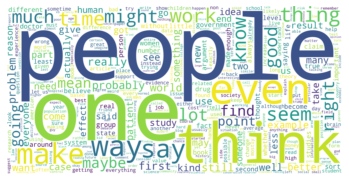

In [31]:
# Create and generate a word cloud image:
wordcloud = WordCloud(background_color='white', width= 4000, height = 2000, max_words = 400).generate(cleaned_text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [32]:
wordcloud.to_file('../../out/wordclouds/ssc_wordcloud.jpg')

## BOW

In [22]:
#cleaned_text for bag of words
with open('../../data/ssc/ssc_for_BOW.txt', 'w+', encoding='utf-8') as f:
    f.write(cleaned_text)